In [11]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

## 1. Load data

In [5]:
file_path = '/Users/seungjaelee/Desktop/textanalytics_project/datasets/imdb/imdb_cleaned.csv'
cleaned_data = pd.read_csv(file_path)
cleaned_data.head()

,movie_id,description,genre,description_length,clean_description,summary
0,tt12783454,Elle Evans (Joey King) has finally completed h...,romance,2103,elle evans joey king finally complete high sch...,"It's the next day and Elle, Lee, Noah, and Rac..."
1,tt1798632,A young girl tries to understand how she myste...,horror,290,young girl try understand mysteriously gain po...,After being experimented on by a secret govern...
2,tt9214832,"In 1800s England, a well meaning but selfish y...",comedy,481,1800s england well mean selfish young woman me...,Emma starts making a match for Harriet and Mr ...
3,tt8522006,Abby Holland (Kristen Stewart) and Harper Cald...,romance,736,abby holland kristen stewart harper caldwell m...,Abby dislikes Christmas since her parents pass...
4,tt21249656,Olga and Maks are 15 years apart. She is a suc...,romance,234,olga mak year apart successful woman establish...,Olga and Maks are 15 years apart. She is a suc...


## 2. Find Optimal Input Configuration for Each Model - Naive Bayes and Random Forest
### 2-1. Define input strategies

In [ ]:
input_strategies = {
    'clean_description': cleaned_data['clean_description'].astype(str),
    'summary': cleaned_data['summary'].astype(str),
    'combined': cleaned_data['summary'].astype(str) + " " + cleaned_data['clean_description'].astype(str)
}

### 2-2. Train, Test Split

In [7]:
# Target variable
y = cleaned_data['genre']

# Split data once
X_all = cleaned_data.index
X_train_idx, X_test_idx, y_train, y_test = train_test_split(
    X_all, y, stratify=y, test_size=0.2, random_state=42
)

In [8]:
# List of max_features to test
max_features_list = [500, 1000, 2000, 3000, 4000, 5000]

# Result containers
nb_results = []
rf_results = []

### 2-3. Run experiments

In [9]:
for input_name, full_text in input_strategies.items():
    X_train_text = full_text.loc[X_train_idx]
    X_test_text = full_text.loc[X_test_idx]

    for max_feat in max_features_list:
        vectorizer = TfidfVectorizer(max_features=max_feat)
        X_train_vec = vectorizer.fit_transform(X_train_text)
        X_test_vec = vectorizer.transform(X_test_text)

        # Naive Bayes
        nb = MultinomialNB()
        nb.fit(X_train_vec, y_train)
        nb_preds = nb.predict(X_test_vec)
        nb_f1 = f1_score(y_test, nb_preds, average='macro')
        nb_results.append((input_name, max_feat, nb_f1))

        # Random Forest
        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf.fit(X_train_vec, y_train)
        rf_preds = rf.predict(X_test_vec)
        rf_f1 = f1_score(y_test, rf_preds, average='macro')
        rf_results.append((input_name, max_feat, rf_f1))

        print(f"[{input_name}] max_features={max_feat:<5} | NB F1={nb_f1:.4f} | RF F1={rf_f1:.4f}")

[clean_description] max_features=500   | NB F1=0.6714 | RF F1=0.6347
[clean_description] max_features=1000  | NB F1=0.7148 | RF F1=0.6280
[clean_description] max_features=2000  | NB F1=0.7199 | RF F1=0.6545
[clean_description] max_features=3000  | NB F1=0.7043 | RF F1=0.6437
[clean_description] max_features=4000  | NB F1=0.7354 | RF F1=0.6600
[clean_description] max_features=5000  | NB F1=0.7523 | RF F1=0.6591
[summary] max_features=500   | NB F1=0.6049 | RF F1=0.5128
[summary] max_features=1000  | NB F1=0.6475 | RF F1=0.5885
[summary] max_features=2000  | NB F1=0.6468 | RF F1=0.5471
[summary] max_features=3000  | NB F1=0.6554 | RF F1=0.5699
[summary] max_features=4000  | NB F1=0.6525 | RF F1=0.5948
[summary] max_features=5000  | NB F1=0.6761 | RF F1=0.5535
[combined] max_features=500   | NB F1=0.6536 | RF F1=0.6439
[combined] max_features=1000  | NB F1=0.6868 | RF F1=0.6455
[combined] max_features=2000  | NB F1=0.7237 | RF F1=0.6580
[combined] max_features=3000  | NB F1=0.7282 | RF F1

In [10]:
best_nb = max(nb_results, key=lambda x: x[2])
best_rf = max(rf_results, key=lambda x: x[2])

print("\nBest Configuration")
print(f"Naive Bayes: input = '{best_nb[0]}', max_features = {best_nb[1]}, macro F1 = {best_nb[2]:.4f}")
print(f"Random Forest: input = '{best_rf[0]}', max_features = {best_rf[1]}, macro F1 = {best_rf[2]:.4f}")


Best Configuration
Naive Bayes: input = 'clean_description', max_features = 5000, macro F1 = 0.7523
Random Forest: input = 'combined', max_features = 4000, macro F1 = 0.6937


## 3. Naive Bayes (clean_description, 5000)
### 3-1. Define Input Text (clean_description)

In [19]:
X_nb_train = cleaned_data.loc[X_train_idx, 'clean_description'].astype(str)
X_nb_test = cleaned_data.loc[X_test_idx, 'clean_description'].astype(str)

### 3-2. TF-IDF Vectorization (max_features = 5000)

In [20]:
vectorizer_nb = TfidfVectorizer(max_features=5000)
X_nb_train_vec = vectorizer_nb.fit_transform(X_nb_train)
X_nb_test_vec = vectorizer_nb.transform(X_nb_test)

### 3-3. Train Naive Bayes Model and Predict

In [21]:
nb_model = MultinomialNB()
nb_model.fit(X_nb_train_vec, y_train)
nb_preds = nb_model.predict(X_nb_test_vec)

### 3-4. Evaluation Report (Precision, Recall, F1)

In [22]:
print("=== Naive Bayes Classification Report ===")
print(classification_report(y_test, nb_preds))

=== Naive Bayes Classification Report ===
              precision    recall  f1-score   support

      action       0.88      0.86      0.87        50
      comedy       0.65      0.56      0.60        50
      horror       0.81      0.88      0.85        50
     romance       0.67      0.72      0.69        50

    accuracy                           0.76       200
   macro avg       0.75      0.75      0.75       200
weighted avg       0.75      0.76      0.75       200



### 3-5. Confusion Matrix (Naive Bayes)

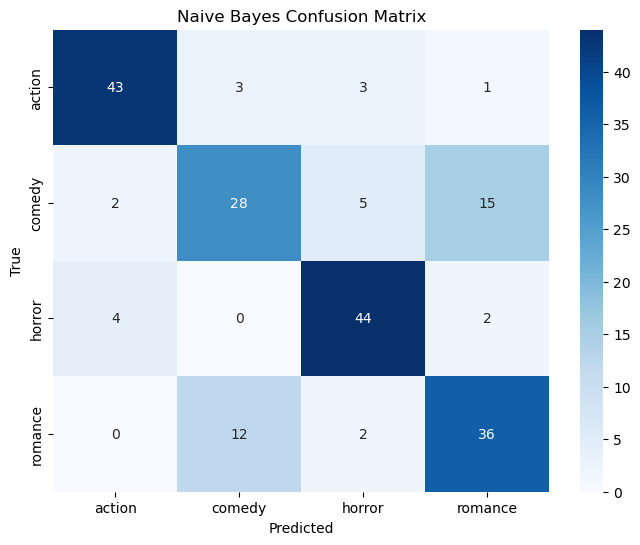

In [23]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, nb_preds), annot=True, fmt="d", cmap="Blues",
            xticklabels=nb_model.classes_, yticklabels=nb_model.classes_)
plt.title("Naive Bayes Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

### 3-6. Top 10 Words Per Genre (WordCloud)

In [33]:
nb_feature_names = vectorizer_nb.get_feature_names_out()
nb_top_words = set()

for i, label in enumerate(nb_model.classes_):
    top10 = np.argsort(nb_model.feature_log_prob_[i])[-10:]
    print(f"\nTop words for {label}:")
    words = [nb_feature_names[j] for j in top10]
    nb_top_words.update(words)
    print(", ".join(words))


Top words for action:
war, must, force, find, man, mission, world, team, kill, take

Top words for comedy:
school, new, take, family, one, make, find, life, friend, get

Top words for horror:
friend, mother, woman, begin, family, night, young, find, house, girl

Top words for romance:
get, family, find, woman, story, young, relationship, meet, life, love


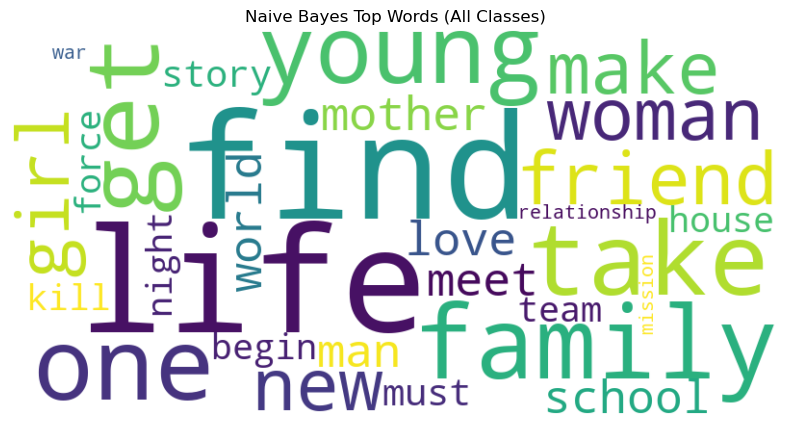

In [34]:
avg_log_probs = np.mean(nb_model.feature_log_prob_, axis=0)  # shape: (n_features,)
log_prob_dict = {nb_feature_names[i]: avg_log_probs[i] for i in range(len(avg_log_probs)) if nb_feature_names[i] in nb_top_words}

wordcloud_nb = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(log_prob_dict)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_nb, interpolation='bilinear')
plt.axis('off')
plt.title("Naive Bayes Top Words (All Classes)")
plt.show()

### 3-7. Misclassified Examples

In [25]:
X_nb_test_reset = X_nb_test.reset_index(drop=True)
y_test_reset = y_test.reset_index(drop=True)
for i in range(len(nb_preds)):
    if nb_preds[i] != y_test_reset[i]:
        print(f"\nText: {X_nb_test_reset[i][:200]}...")
        print(f"True: {y_test_reset[i]} | Predicted: {nb_preds[i]}")
        if i >= 2: break


Text: land gig lifetime new york jazz pianist suddenly find trapped strange land earth afterlife joe middleschool band teacher whose life hasnt quite go way expect true passion jazz he good travel another r...
True: comedy | Predicted: romance


## 4. Random Forest (summary + cleaned_description, 4000)
### 4-1. Define Input Text (summary + cleaned_description)

In [26]:
X_rf_train = (cleaned_data.loc[X_train_idx, 'summary'].astype(str) + " " +
              cleaned_data.loc[X_train_idx, 'clean_description'].astype(str))
X_rf_test = (cleaned_data.loc[X_test_idx, 'summary'].astype(str) + " " +
             cleaned_data.loc[X_test_idx, 'clean_description'].astype(str))

### 4-2. TF-IDF Vectorization (max_features = 4000)

In [27]:
vectorizer_rf = TfidfVectorizer(max_features=4000)
X_rf_train_vec = vectorizer_rf.fit_transform(X_rf_train)
X_rf_test_vec = vectorizer_rf.transform(X_rf_test)

### 4-3. Train Random Forest Model and Predict

In [28]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_rf_train_vec, y_train)
rf_preds = rf_model.predict(X_rf_test_vec)

### 4-4. Evaluation Report (Precision, Recall, F1)

In [29]:
print("\n=== Random Forest Classification Report ===")
print(classification_report(y_test, rf_preds))


=== Random Forest Classification Report ===
              precision    recall  f1-score   support

      action       0.80      0.88      0.84        50
      comedy       0.62      0.40      0.49        50
      horror       0.76      0.82      0.79        50
     romance       0.61      0.72      0.66        50

    accuracy                           0.70       200
   macro avg       0.70      0.71      0.69       200
weighted avg       0.70      0.70      0.69       200



### 4-5. Confusion Matrix (Random Forest)

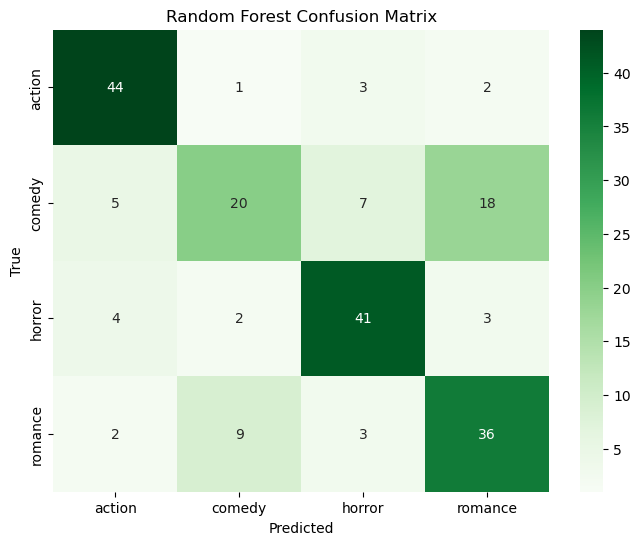

In [30]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, rf_preds), annot=True, fmt="d", cmap="Greens",
            xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

### 4-6. Top 10 Words Per Genre (WordCloud)

In [35]:
rf_feature_names = vectorizer_rf.get_feature_names_out()
importances = rf_model.feature_importances_

# Get top 20 important words (optional: adjust number)
top_indices = np.argsort(importances)[-20:]
top_words = [rf_feature_names[i] for i in top_indices]
print("\nTop 20 Important Words (Random Forest):")
print(", ".join(top_words))


Top 20 Important Words (Random Forest):
young, kill, is, and, that, by, horror, take, of, make, her, to, dangerous, she, mission, relationship, meet, his, the, love


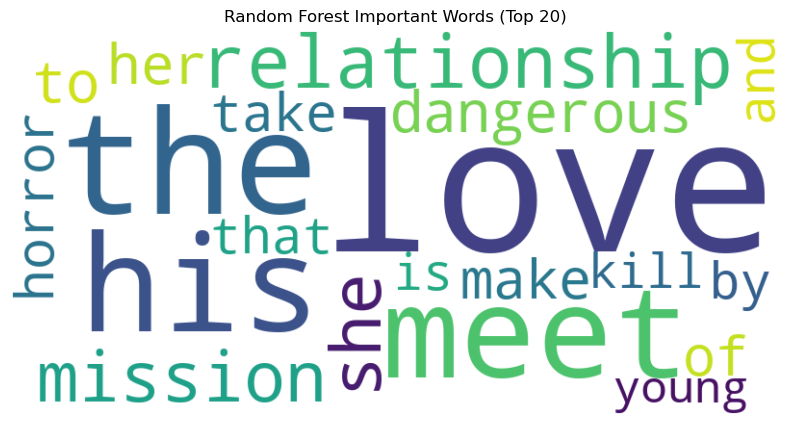

In [36]:
importance_dict = {rf_feature_names[i]: importances[i] for i in top_indices}

wordcloud_rf = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(importance_dict)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_rf, interpolation='bilinear')
plt.axis('off')
plt.title("Random Forest Important Words (Top 20)")
plt.show()

### 4-7. Misclassified Examples

In [37]:
X_rf_test_reset = X_rf_test.reset_index(drop=True)
for i in range(len(rf_preds)):
    if rf_preds[i] != y_test_reset[i]:
        print(f"\nText: {X_rf_test_reset[i][:200]}...")
        print(f"True: {y_test_reset[i]} | Predicted: {rf_preds[i]}")
        if i >= 2: break


Text: Young Rakel has a whole lot of other plans than becoming a mother. Is it her or the baby? Rakel already had many plans for her life, wanted to become an astronaut or a forester, but being a mother is ...
True: comedy | Predicted: romance

Text: In the next installment, the survivors of the Ghostface killings leave Woodsboro behind and start a fresh chapter in New York City. Following the latest Ghostface killings, the four survivors leave Wo...
True: horror | Predicted: action
